<a href="https://colab.research.google.com/github/yoneda-kg/sparce/blob/main/ISTA%2C_AMP_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

In [2]:
class Base:
    def __init__(self, M, N):
        self.M = M
        self.N = N
        self.A = np.hstack((np.eye(M), np.zeros((M, N-M))))

In [3]:
class iidGaussian(Base):
    def __init__(self, M, N, m=0, v=1):
        super().__init__(M, N)
        self.A = self.set_matrix(M, N, m, v)

    def set_matrix(self, row, column, mean, var):
        """
        Return i.i.d(independent and identically distributed) Gaussian Matrix
        """
        return np.random.normal(mean, var**0.5, (row, column))

In [4]:
def bernouli_gaussian(n, rho):
    """
    generation of signal according to Bernouli_Gaussian distribution
    """
    rand = np.random.rand(n)
    x = np.zeros((n, 1))
    for i in range(n):
        if rand[i] < rho/2:
            x[i] = norm.ppf(rand[i]/rho, loc=0, scale=1/rho**0.5)
        elif 1 - rho/2 < rand[i]:
            x[i] = norm.ppf((rand[i] - (1-rho))/rho, loc=0, scale=1/rho**0.5)
    return x

In [5]:
def soft_threshold(x, Lambda):
    """
    soft-thresholding function
    """
    return np.maximum(np.abs(x) - Lambda, 0.0) * np.sign(x)

In [74]:
class ISTA:
    def __init__(self, A, x, sigma):
      self.A=A
      self.M, self.N=A.shape
      self.x=x
      self.sigma=sigma
      Ax=np.dot(A, x)
      n=np.random.normal(0, sigma**2, (self.M, 1))
      self.y=Ax+n
      self.s=np.zeros((self.N, 1))
      self.mse=np.array([None])
      self.AT=np.transpose(A)

      """
      #ここから
      self.K = np.sum(x != 0)
      self.A2 = self.AT @ self.A
      self.zero_index = x == 0
      self.non_zero_index = x != 0
      self.mse_zero = np.array([None])
      self.mse_non_zero = np.array([None])
      self.mse_hist_bins = []
      #ここまでの変数の意味は分からない
      """

    def estimate(self, T=20, tau=0.5):
      L=self.__set__lipchitz()
      ganma=1/(tau*L)
      for _ in range(T):
        r=self._update_r()
        w=self._update_w(ganma, r)
        self.s=self._update_s(w, 1/L)
        self.mse=self._add_mse()

    def __set__lipchitz(self):
      L=np.linalg.norm(self.AT.dot(self.A),ord=2)/(0.5)
      return L

    def _update_r(self):
      return self.y - np.dot(self.A, self.s)

    def _update_w(self, ganma, r):
      return self.s + ganma * np.dot(self.AT, r)

    def _update_s(self, w, thre):
      return soft_threshold(w, thre)

    def _add_mse(self):
      mse = np.linalg.norm(self.s - self.x)**2 / self.N
      self.mse=np.append(self.mse, mse)
      return self.mse

      """
      #ここから
      sum_4_zero = 0
      sum_4_non_zero = 0
      for k, v in enumerate(self.zero_index):
        if v:
          sum_4_zero += self._square_error_4_component(k)
        elif not v:
          sum_4_non_zero += self._square_error_4_component(k)
        else:
          raise ValueError("Not Correct Value")
      self.mse_zero = np.append(self.mse_zero, sum_4_zero[0] / (self.N - self.K))
      self.mse_non_zero = np.append(self.mse_non_zero, sum_4_non_zero[0] / self.K)

    def _square_error_4_component(self, i):
        return (self.s[i] - self.x[i])**2
    #ここまでも分からない
    """

    def result_ISTA(self):
      plt.plot(self.x.real)
      plt.plot(self.s.real)
      plt.grid()

    def result_ISTA_MSE(self):
      MSE=[]
      MSE=np.append(MSE, self.mse)
      Figure, ax = plt.subplots()#グラフオブジェクトを生成
      plt.grid()
      plt.yscale('log')
      plt.plot(MSE)
      ax.set_ylim([0.0001,10])
      plt.xticks(np.arange(1, T+1, step=1))
      plt.xlabel("iteration")
      plt.ylabel("MSE")

In [85]:
class AMP(ISTA):
    def __intit__(self, A, x, sigma):
      super().__init__(A, x, sigma)
      self.tau=np.array([None])

    def estimate(self, T=20):
      Onsager=np.zeros((self.M, 1))
      for _ in range(T):
        r=self._update_r()
        w=self._update_w(r+Onsager)
        tau=self._update_tau(r+Onsager)
        self.s=self._update_s(w, tau)
        Onsager=np.sum(self.s != 0)/self.M*(r+Onsager) #Onsager項のつけ方がよくわからない
        self._add_mse

    def _update_w(self, r):
       return self.s+np.dot(self.AT, r)

    def _update_tau(self, r):
        return self.tau.append((np.linalg.norm(r)**2)/self.M)

    def _update_s(self, w, tau):
      return soft_threshold(w, tau**0.5)

    def result_AMP(self):
      plt.plot(self.x.real)
      plt.plot(self.s.real)
      plt.grid()

In [86]:
N = 1000
alpha = 0.5
M = int(alpha*N)
rho = 0.1
T = 30
x = bernouli_gaussian(N, rho)
sigma = 0.1
iidG = iidGaussian(M, N, 0, 1/M)

In [87]:
tmp_iidG = [ISTA(iidG.A, x, sigma),
            AMP(iidG.A, x, sigma)]

ISTA

In [88]:
tmp_iidG[0].estimate(T=T)

AMP

In [89]:
tmp_iidG[1].estimate(T=T)

AttributeError: ignored

<ipython-input-69-5ee1d386d2c3>:82: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


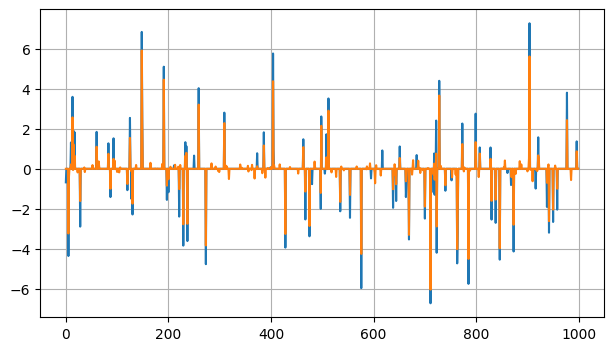

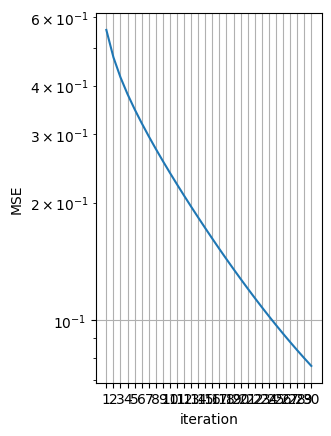

In [73]:
tmp_iidG[0].result_ISTA()

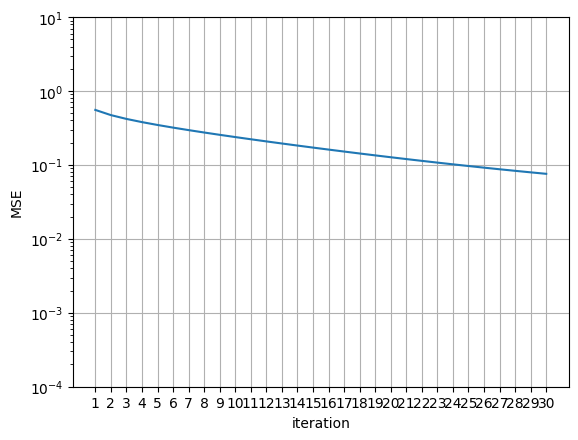

In [64]:
tmp_iidG[0].result_ISTA_MSE()